<a href="https://colab.research.google.com/github/hyunholee26/short-term-river-level-prediction-using-LSTM-with-MC-dropout/blob/main/%5Bwlp_jingwan%5D_4_lstm_uncertainty_w_diff1_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 5.6 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.


In [ ]:
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline
print(tf.__version__)


TensorFlow 1.x selected.


Using TensorFlow backend.


1.15.2


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
path = '/content/drive/MyDrive/data/flood/'

raw_period = {'startdt': ['20140101', '20140701', '20150101', '20150701', '20160101', '20160701', '20170101', '20170701', '20180101', '20180701', '20190101', '20190701', '20200101', '20200701', '20210101'],
                'enddt': ['20140630', '20141231', '20150630', '20151231', '20160630', '20161231', '20170630', '20171231', '20180630', '20181231', '20190630', '20191231', '20200630', '20201231', '20210630']}

df_period = pd.DataFrame(raw_period)
df_period

,startdt,enddt
0,20140101,20140630
1,20140701,20141231
2,20150101,20150630
3,20150701,20151231
4,20160101,20160630
5,20160701,20161231
6,20170101,20170630
7,20170701,20171231
8,20180101,20180630
9,20180701,20181231


In [ ]:
# 진관교 및 상류지역 수위 및 강우량 지점 코드 
# 해당 코드명이 파일 이름으로 포함되어 있음

raw_obscd = {'obscd': ['1018620', '1018625', '1018630', '10184110', '10184220'],
            'desc': ['수위_남양주시 부평교', '수위_남양주시 내곡교', '수위_남양주시 진관교', '강우_진관교', '강우_진접읍사무소']}

df_obscd = pd.DataFrame(raw_obscd)
df_obscd


,obscd,desc
0,1018620,수위_남양주시 부평교
1,1018625,수위_남양주시 내곡교
2,1018630,수위_남양주시 진관교
3,10184110,강우_진관교
4,10184220,강우_진접읍사무소


In [ ]:
# 기준이 되는 Date를 생성함

start = datetime.datetime.strptime("2015050101", "%Y%m%d%H")
end = datetime.datetime.strptime("2020110123", "%Y%m%d%H")
date_generated = [start + datetime.timedelta(hours=x) for x in range(0, (end-start).days * 24 + 23)]

df = pd.DataFrame(date_generated, columns =['Date'])
df['ymdh'] = df['Date'].apply(lambda x: int(x.strftime('%Y%m%d%H'))) 
df

,Date,ymdh
0,2015-05-01 01:00:00,2015050101
1,2015-05-01 02:00:00,2015050102
2,2015-05-01 03:00:00,2015050103
3,2015-05-01 04:00:00,2015050104
4,2015-05-01 05:00:00,2015050105
...,...,...
48282,2020-11-01 19:00:00,2020110119
48283,2020-11-01 20:00:00,2020110120
48284,2020-11-01 21:00:00,2020110121
48285,2020-11-01 22:00:00,2020110122


In [ ]:
# 앞에서 만든 데이터프레임을 이용하여, 각 파일들을 읽고 합치는 작업을 함

for i, row_i in df_obscd.iterrows():
  obscd = row_i['obscd']   
  
  files = glob.glob(path + '*' + obscd + '*.csv')
  files.sort()
  print(files)
  
  # Read files
  for index, file in enumerate(files):
    #print('Reading files ... : ' + file)
    try:
      if(index == 0):
        df_wl = pd.read_csv(file)
      else:
        temp = pd.read_csv(file)
        df_wl = df_wl.append(temp)
    except:
      print('Pass file : ' + file)
      continue
  df_wl.columns = ['ymdh', obscd]
  df = df.merge(df_wl, how='left', on = 'ymdh')
  #display(df)

['/content/drive/MyDrive/data/flood/wl_1018620_20140101_20140630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20140701_20141231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20150101_20150630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20150701_20151231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20160101_20160630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20160701_20161231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20170101_20170630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20170701_20171231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20180101_20180630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20180701_20181231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20190101_20190630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20190701_20191231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20200101_20200630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20200701_20201231.csv', '/content/drive/MyD

In [ ]:
# 결측치는 선형보간으로 처리
# LSTM의 경우 연속된 값을 입력으로 해야함에 따라 결측치 보간을 필수적으로 해야함

df['1018620'] = df['1018620'].interpolate(limit = 1)
df['1018625'] = df['1018625'].interpolate(limit = 1)
df['1018630'] = df['1018630'].interpolate(limit = 1)
df['10184110'] = df['10184110'].fillna(0)
df['10184220'] = df['10184220'].fillna(0)
# 보간 참고

,Date,ymdh,1018620,1018625,1018630,10184110,10184220
46103,2020-08-03 00:00:00,2020080300,1.16,1.645,1.135,0.0,0.0
46104,2020-08-03 01:00:00,2020080301,1.14,1.620,1.130,1.0,0.0
46105,2020-08-03 02:00:00,2020080302,1.15,1.610,1.090,0.0,5.0
46106,2020-08-03 03:00:00,2020080303,1.38,1.620,1.090,13.0,6.0
46107,2020-08-03 04:00:00,2020080304,1.41,1.780,1.200,8.0,1.0
46108,2020-08-03 05:00:00,2020080305,1.43,1.900,1.440,10.0,12.0
46109,2020-08-03 06:00:00,2020080306,1.71,2.100,1.700,15.0,7.0
46110,2020-08-03 07:00:00,2020080307,1.59,2.550,2.170,10.0,16.0
46111,2020-08-03 08:00:00,2020080308,1.49,2.350,2.000,2.0,8.0
46112,2020-08-03 09:00:00,2020080309,1.80,2.530,1.990,22.0,20.0


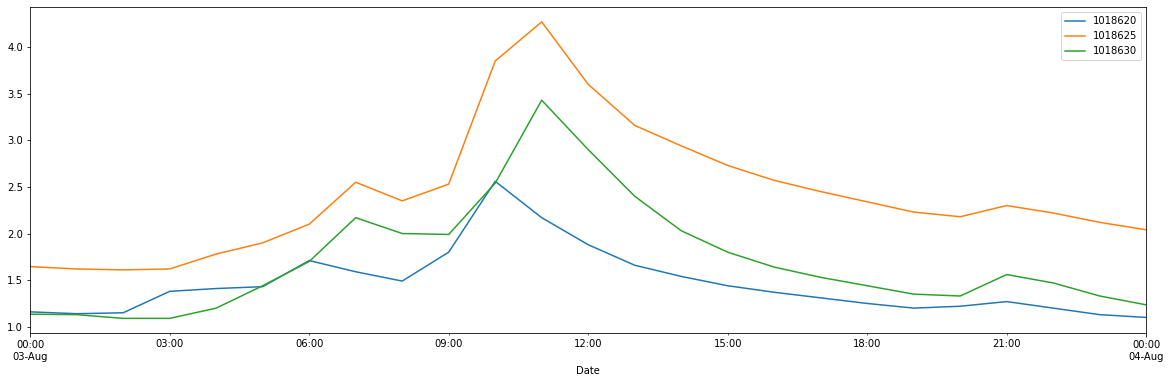

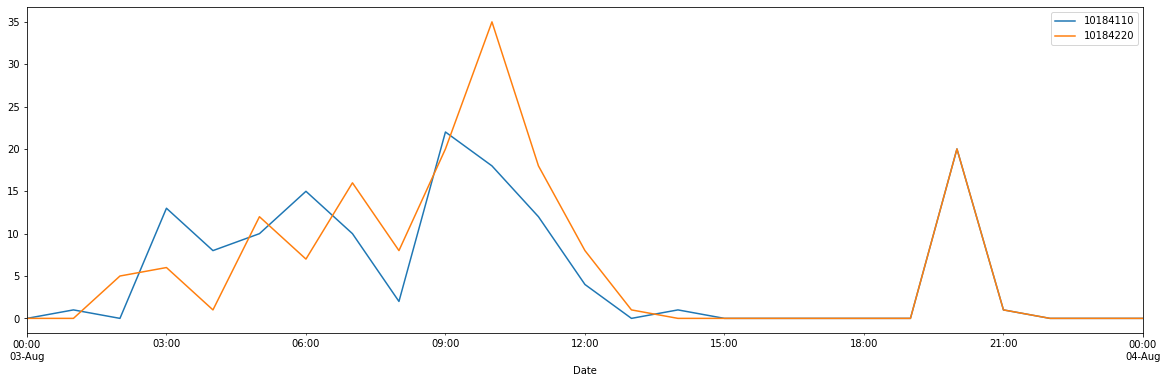

In [ ]:
# 데이터 구조 체크 및 시각화

start = 2020080300
end = 2020080400

df_temp = df[(df['ymdh'] >= start) & (df['ymdh'] <= end)][['Date', '1018620', '1018625', '1018630']].set_index('Date')
df_temp.plot(figsize=(20,6))
df_temp = df[(df['ymdh'] >= start) & (df['ymdh'] <= end)][['Date', '10184110', '10184220']].set_index('Date')
df_temp.plot(figsize=(20,6))

display(df[(df['ymdh'] >= start) & (df['ymdh'] <= end)])

In [ ]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df.drop(columns = ['Date', 'ymdh']).copy()
df_in

,1018620,1018625,1018630,10184110,10184220
0,0.20,1.08,-0.21,0.0,0.0
1,0.20,1.08,-0.21,0.0,0.0
2,0.20,1.08,-0.21,0.0,0.0
3,0.20,1.08,-0.22,0.0,0.0
4,0.20,1.08,-0.22,0.0,0.0
...,...,...,...,...,...
48282,0.15,1.07,-0.11,0.0,0.0
48283,0.15,1.07,-0.11,0.0,0.0
48284,0.15,1.07,-0.10,0.0,0.0
48285,0.15,1.08,-0.10,0.0,0.0


In [ ]:
# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# save the scaler
dump(scaler, open(path + 'scaler_1018630_8.pkl', 'wb'))

df_in_scaled


,1018620,1018625,1018630,10184110,10184220
0,0.063492,0.137838,0.026738,0.0,0.0
1,0.063492,0.137838,0.026738,0.0,0.0
2,0.063492,0.137838,0.026738,0.0,0.0
3,0.063492,0.137838,0.024064,0.0,0.0
4,0.063492,0.137838,0.024064,0.0,0.0
...,...,...,...,...,...
48282,0.043651,0.135135,0.053476,0.0,0.0
48283,0.043651,0.135135,0.053476,0.0,0.0
48284,0.043651,0.135135,0.056150,0.0,0.0
48285,0.043651,0.137838,0.056150,0.0,0.0


In [ ]:
# Min=max 정규화 이후 각 값의 차분(미분)을 계산
# 이절차에 있어서는... 가장 좋은 방법에 대한 검토가 필요함
# 일단 차분후 정규화하는 것보다는 정규화 후 차분하는 것이 더 좋다고 판단함

df_in_scaled['1018620_diff'] = df_in_scaled['1018620'].diff()
df_in_scaled['1018625_diff'] = df_in_scaled['1018625'].diff()
df_in_scaled['1018630_diff'] = df_in_scaled['1018630'].diff()
df_in_scaled[40000:40240]

,1018620,1018625,1018630,10184110,10184220,1018620_diff,1018625_diff,1018630_diff
40000,0.079365,0.129730,0.040107,0.0,0.0,0.000000,0.0,0.0
40001,0.079365,0.129730,0.040107,0.0,0.0,0.000000,0.0,0.0
40002,0.079365,0.129730,0.040107,0.0,0.0,0.000000,0.0,0.0
40003,0.079365,0.129730,0.040107,0.0,0.0,0.000000,0.0,0.0
40004,0.075397,0.129730,0.040107,0.0,0.0,-0.003968,0.0,0.0
...,...,...,...,...,...,...,...,...
40235,0.067460,0.121622,0.034759,0.0,0.0,-0.003968,0.0,0.0
40236,0.067460,0.121622,0.034759,0.0,0.0,0.000000,0.0,0.0
40237,0.067460,0.121622,0.034759,0.0,0.0,0.000000,0.0,0.0
40238,0.067460,0.121622,0.034759,0.0,0.0,0.000000,0.0,0.0


In [ ]:
# 240시간(10일)에 대해 8개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1시간을 예측으로 함

x_range = 240
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = '1018630'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
print(dataset_y_reshaped)

(47205, 240, 8)
[[[ 0.06349206  0.13783784  0.02673797 ...  0.          0.
    0.        ]
  [ 0.06349206  0.13783784  0.02673797 ...  0.          0.
    0.        ]
  [ 0.06349206  0.13783784  0.02406417 ...  0.          0.
   -0.0026738 ]
  ...
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]]

 [[ 0.06349206  0.13783784  0.02673797 ...  0.          0.
    0.        ]
  [ 0.06349206  0.13783784  0.02406417 ...  0.          0.
   -0.0026738 ]
  [ 0.06349206  0.13783784  0.02406417 ...  0.          0.
    0.        ]
  ...
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]
  [ 0.0515873   0.13243243  0.01871658 ...  0.          0.
    0.        ]]

 [[ 0.06349206  0.13783784  0.02406417 ...  0.          0.
   -0.002

In [ ]:
print(np.isnan(dataset_X_reshaped).sum())
print(np.isnan(dataset_y_reshaped).sum())

0
0


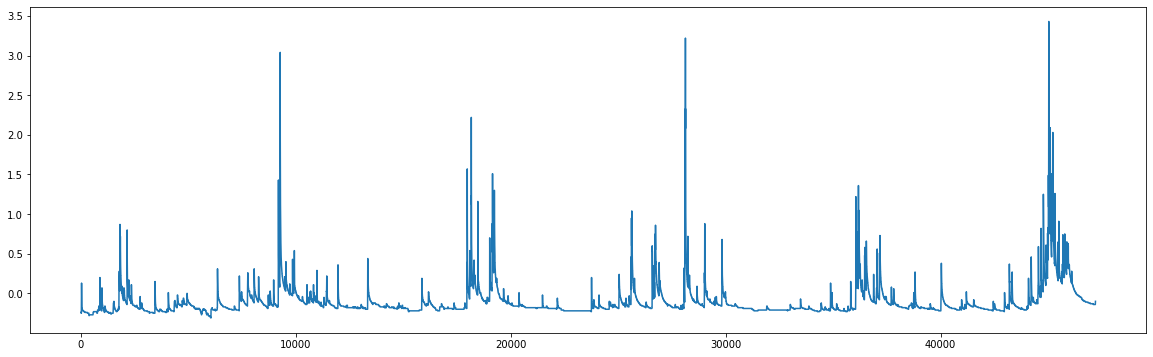

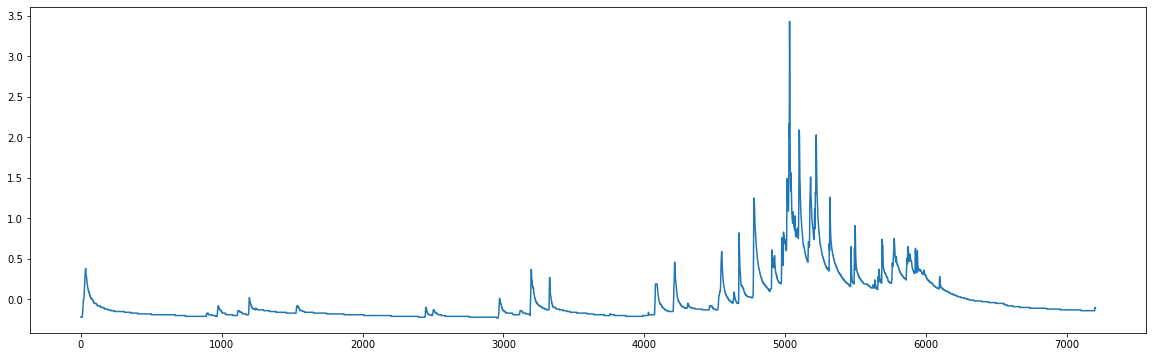

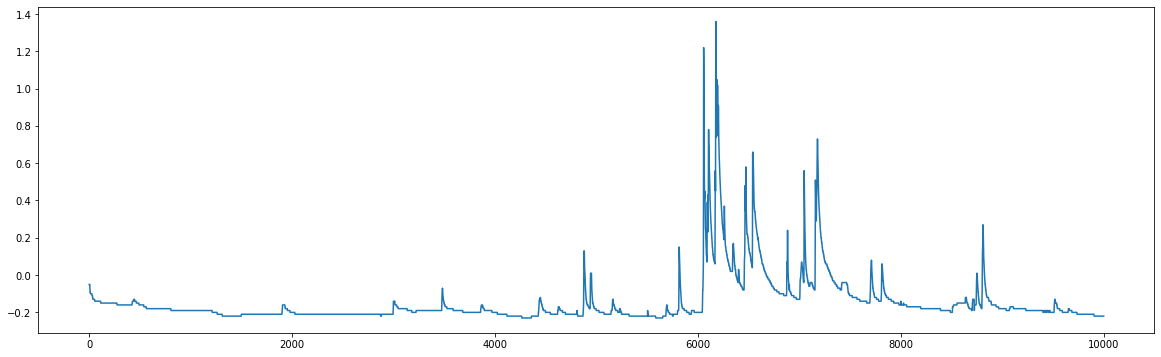

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(dataset_y_reshaped)
plt.show()

plt.figure(figsize=(20,6))
plt.plot(dataset_y_reshaped[40000:])
plt.show()

plt.figure(figsize=(20,6))
plt.plot(dataset_y_reshaped[30000:40000])
plt.show()

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 50000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:30000,:,:]
X_val = dataset_X_reshaped[30000:40000,:,:]
X_test = dataset_X_reshaped[40000:,:,:]

y_train = dataset_y_reshaped[0:30000]
y_val = dataset_y_reshaped[30000:40000]
y_test = dataset_y_reshaped[40000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30000, 240, 8)
(7205, 240, 8)
(30000, 1)
(7205, 1)


In [ ]:
from keras.models import model_from_json

def load_model(fn):
  # loading model architecture from json file
  json_file = open(fn + '.json', 'r')
  json_model = model_from_json(json_file.read())
  json_model.load_weights(fn + '.h5')
  opt = Adam()
  json_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  return json_model

def predict_dist(X, model, num_samples):
    preds = [model.predict(X) for _ in range(num_samples)]
    return np.hstack(preds)
    
model = load_model(path + 'lstm_base_jingwan_w_diff1')
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 240, 8)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 240, 256)          271360    
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
OUTPUT (Dense)               (None, 1)                 257       
Total params: 796,929
Trainable params: 796,929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
strix = 40000

X_test = dataset_X_reshaped[strix:,:,:]
y_test = dataset_y_reshaped[strix:]

print(X_test.shape)
print(y_test.shape)

(7205, 240, 8)
(7205, 1)


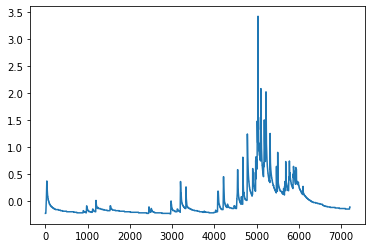

In [ ]:
plt.plot(y_test)

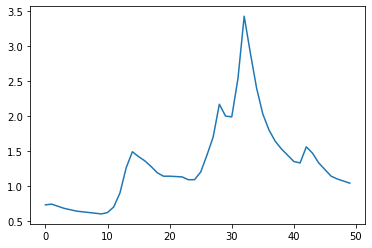

In [ ]:
plt.plot(y_test[5000:5050])

In [ ]:
y_pred_dist = predict_dist(X_test[5000:5050], model, 30)
pred_mean = y_pred_dist.mean(axis=1)
pred_std = y_pred_dist.std(axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(pred_mean.flatten(), y_test[5000:5050].flatten()) 
np.sqrt(MSE)

0.10009705394693856

In [ ]:
y_test[5000:5050][:10]

array([[0.73],
       [0.74],
       [0.71],
       [0.68],
       [0.66],
       [0.64],
       [0.63],
       [0.62],
       [0.61],
       [0.6 ]])

In [ ]:
a = df[df_in['1018630'] == 0.73].index + 8
b = df[df_in['1018630'] == 0.74].index + 7
c = df[df_in['1018630'] == 0.71].index + 6
d = df[df_in['1018630'] == 0.68].index + 5
e = df[df_in['1018630'] == 0.66].index + 4
f = df[df_in['1018630'] == 0.64].index + 3
g = df[df_in['1018630'] == 0.63].index + 2
h = df[df_in['1018630'] == 0.62].index + 1
i = df[df_in['1018630'] == 0.61].index


list(set(a) & set(b) & set(c) & set(d) & set(e) & set(f) & set(g) & set(h) & set(i))

[46090]

In [ ]:
df[(46090-8):]

,Date,ymdh,1018620,1018625,1018630,10184110,10184220
46082,2020-08-02 03:00:00,2020080203,0.81,1.37,0.73,0.0,0.0
46083,2020-08-02 04:00:00,2020080204,0.81,1.36,0.74,0.0,0.0
46084,2020-08-02 05:00:00,2020080205,0.80,1.36,0.71,0.0,0.0
46085,2020-08-02 06:00:00,2020080206,0.79,1.36,0.68,0.0,0.0
46086,2020-08-02 07:00:00,2020080207,0.79,1.35,0.66,0.0,1.0
...,...,...,...,...,...,...,...
48282,2020-11-01 19:00:00,2020110119,0.15,1.07,-0.11,0.0,0.0
48283,2020-11-01 20:00:00,2020110120,0.15,1.07,-0.11,0.0,0.0
48284,2020-11-01 21:00:00,2020110121,0.15,1.07,-0.10,0.0,0.0
48285,2020-11-01 22:00:00,2020110122,0.15,1.08,-0.10,0.0,0.0


In [ ]:
prob_advisory = []
prob_warning = [] 

threshold_advisory = 2
threshold_warning = 3

for i in range(0,len(y_pred_dist)) :
  ecdf = ECDF(y_pred_dist[i])
  prob_advisory.append(1 - ecdf(2))
  prob_warning.append(1 - ecdf(3))

In [ ]:
strix = 46082
num = 50

df_pred = pd.DataFrame({'Date' : df['Date'][strix:strix+num].values, 'Obs' : y_test[5000:5050].flatten(), 'Pred' : pred_mean.flatten(), 'Upper' : pred_mean + 1.96 * pred_std, 'Lower' : pred_mean - 1.96 * pred_std, 'Prob_adv' : prob_advisory, 'Prob_warn' : prob_warning})
df_pred = df_pred.merge(df[['Date', '10184110',	'10184220']], how='left', on = 'Date')
df_pred


,Date,Obs,Pred,Upper,Lower,Prob_adv,Prob_warn,10184110,10184220
0,2020-08-02 03:00:00,0.730,0.690652,0.724883,0.656421,0.0,0.000000,0.0,0.0
1,2020-08-02 04:00:00,0.740,0.695472,0.729519,0.661424,0.0,0.000000,0.0,0.0
2,2020-08-02 05:00:00,0.710,0.699346,0.731205,0.667486,0.0,0.000000,0.0,0.0
3,2020-08-02 06:00:00,0.680,0.678847,0.709256,0.648438,0.0,0.000000,0.0,0.0
4,2020-08-02 07:00:00,0.660,0.654599,0.681785,0.627413,0.0,0.000000,0.0,1.0
5,2020-08-02 08:00:00,0.640,0.635722,0.655887,0.615557,0.0,0.000000,1.0,0.0
6,2020-08-02 09:00:00,0.630,0.629232,0.659882,0.598583,0.0,0.000000,0.0,0.0
7,2020-08-02 10:00:00,0.620,0.608705,0.635971,0.581439,0.0,0.000000,0.0,0.0
8,2020-08-02 11:00:00,0.610,0.605757,0.631162,0.580351,0.0,0.000000,2.0,1.0
9,2020-08-02 12:00:00,0.600,0.602115,0.630397,0.573834,0.0,0.000000,3.0,8.0


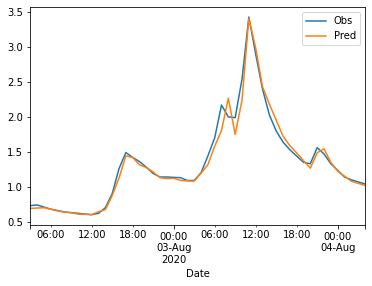

In [ ]:
df_pred.set_index('Date')['2020-08-02 03:00:00':'2020-08-04 04:00:00'][['Obs', 'Pred']].plot()

In [ ]:
df_predict = df_pred[0:end].copy()
df_predict['Obs'][frame-1] = float("nan")
df_predict['10184110'][frame-1] = float("nan")
df_predict['10184220'][frame-1] = float("nan")

df_predict['Obs'][frame:end] = float("nan")
df_predict['Pred'][frame:end] = float("nan")
df_predict['Upper'][frame:end] = float("nan")
df_predict['Lower'][frame:end] = float("nan")
df_predict['10184110'][frame:end] = float("nan")
df_predict['10184220'][frame:end] = float("nan")

df_predict

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

,Date,Obs,Pred,Upper,Lower,Prob_adv,Prob_warn,10184110,10184220
0,2020-08-02 03:00:00,0.730,0.690652,0.724883,0.656421,0.0,0.000000,0.0,0.0
1,2020-08-02 04:00:00,0.740,0.695472,0.729519,0.661424,0.0,0.000000,0.0,0.0
2,2020-08-02 05:00:00,0.710,0.699346,0.731205,0.667486,0.0,0.000000,0.0,0.0
3,2020-08-02 06:00:00,0.680,0.678847,0.709256,0.648438,0.0,0.000000,0.0,0.0
4,2020-08-02 07:00:00,0.660,0.654599,0.681785,0.627413,0.0,0.000000,0.0,1.0
5,2020-08-02 08:00:00,0.640,0.635722,0.655887,0.615557,0.0,0.000000,1.0,0.0
6,2020-08-02 09:00:00,0.630,0.629232,0.659882,0.598583,0.0,0.000000,0.0,0.0
7,2020-08-02 10:00:00,0.620,0.608705,0.635971,0.581439,0.0,0.000000,0.0,0.0
8,2020-08-02 11:00:00,0.610,0.605757,0.631162,0.580351,0.0,0.000000,2.0,1.0
9,2020-08-02 12:00:00,0.600,0.602115,0.630397,0.573834,0.0,0.000000,3.0,8.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: Se

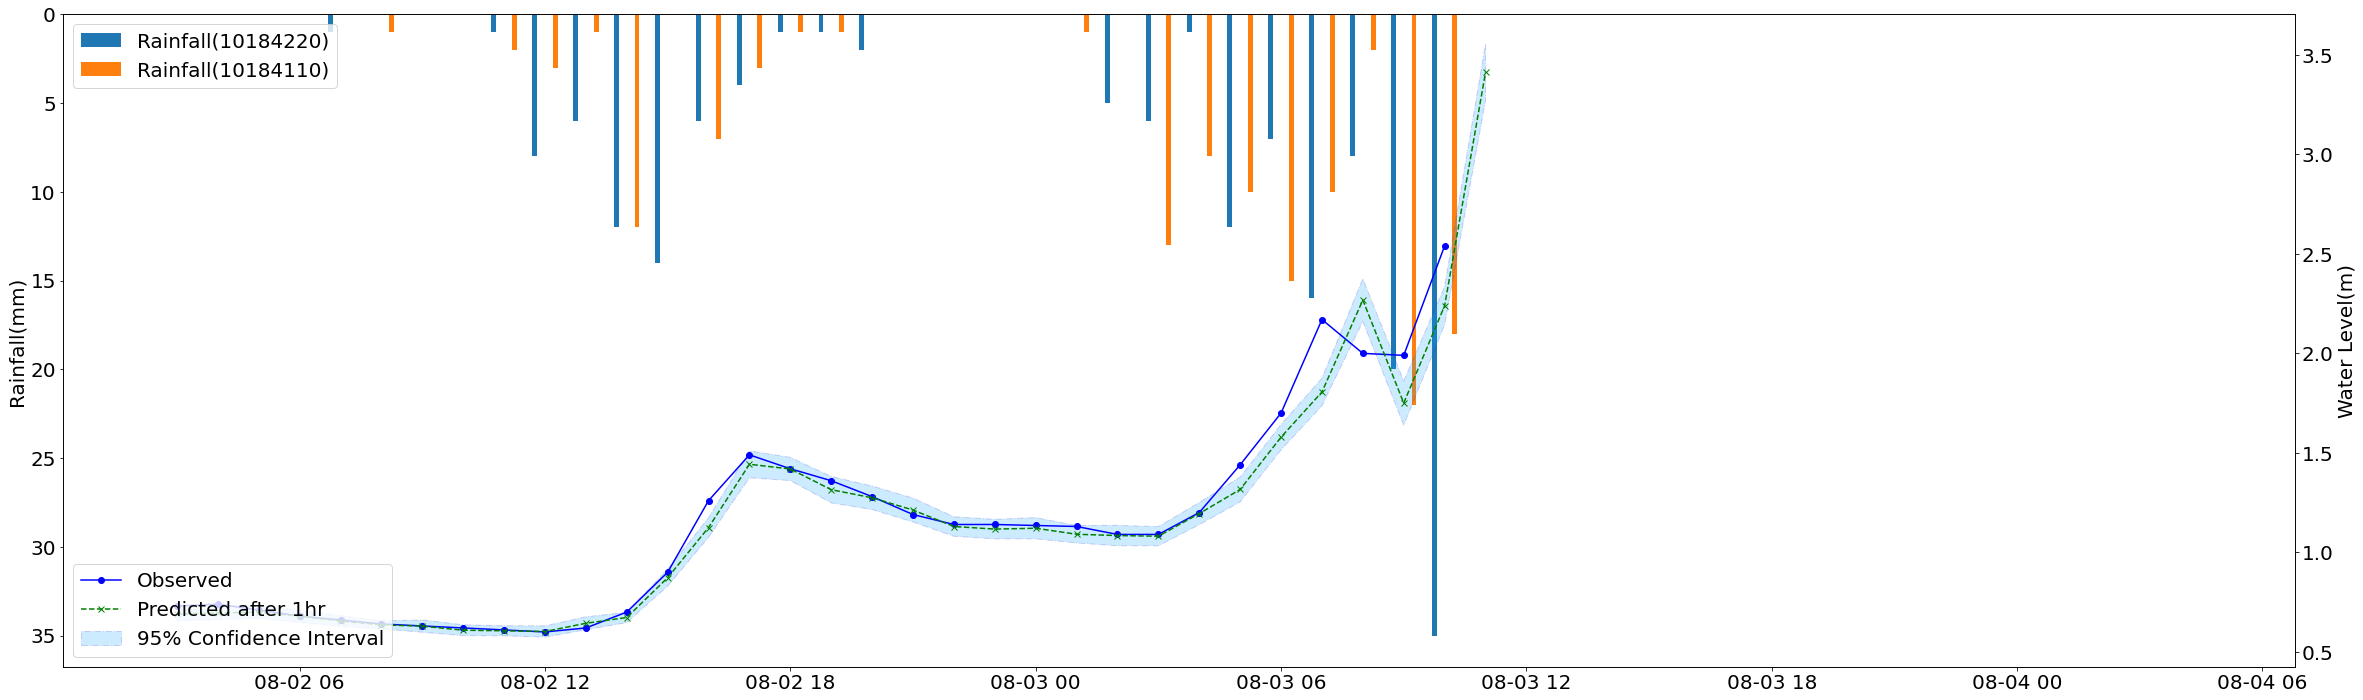

In [ ]:
frame = 33
end = 50
df_predict = df_pred[0:end].copy()
df_predict['Obs'][frame-1] = float("nan")
df_predict['10184110'][frame-1] = 0
df_predict['10184220'][frame-1] = 0

df_predict['Obs'][frame:end] = float("nan")
df_predict['Pred'][frame:end] = float("nan")
df_predict['Upper'][frame:end] = float("nan")
df_predict['Lower'][frame:end] = float("nan")
df_predict['10184110'][frame:end] = 0
df_predict['10184220'][frame:end] = 0

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.005
ax1.bar(df_predict['Date'] - datetime.timedelta(minutes=15), df_predict['10184220'], width=width)
ax1.bar(df_predict['Date'] + datetime.timedelta(minutes=15), df_predict['10184110'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
ax1.legend(('Rainfall(10184220)','Rainfall(10184110)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=1, linestyle='dashdot', antialiased=True)
ax2.legend(('Observed','Predicted after 1hr', '95% Confidence Interval'), loc='lower left', prop={'size': 20})
ax2.set_ylabel('Water Level(m)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: Se

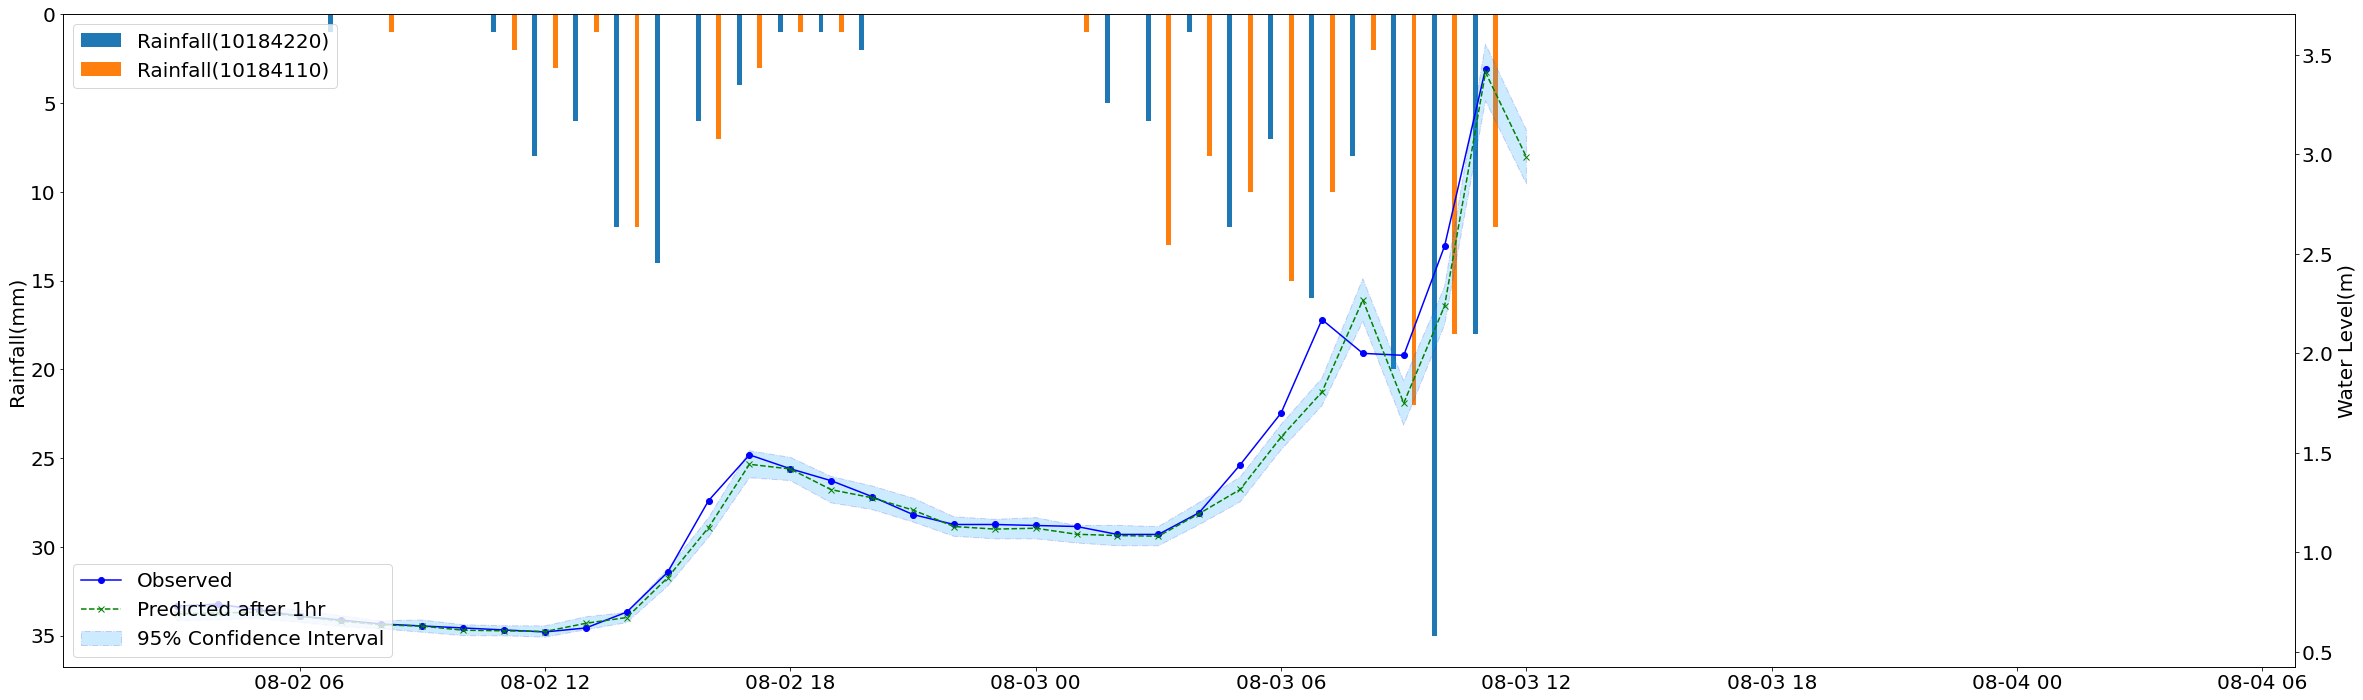

In [ ]:
frame = 34
end = 50
df_predict = df_pred[0:end].copy()
df_predict['Obs'][frame-1] = float("nan")
df_predict['10184110'][frame-1] = 0
df_predict['10184220'][frame-1] = 0

df_predict['Obs'][frame:end] = float("nan")
df_predict['Pred'][frame:end] = float("nan")
df_predict['Upper'][frame:end] = float("nan")
df_predict['Lower'][frame:end] = float("nan")
df_predict['10184110'][frame:end] = 0
df_predict['10184220'][frame:end] = 0

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.005
ax1.bar(df_predict['Date'] - datetime.timedelta(minutes=15), df_predict['10184220'], width=width)
ax1.bar(df_predict['Date'] + datetime.timedelta(minutes=15), df_predict['10184110'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
ax1.legend(('Rainfall(10184220)','Rainfall(10184110)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=1, linestyle='dashdot', antialiased=True)
ax2.legend(('Observed','Predicted after 1hr', '95% Confidence Interval'), loc='lower left', prop={'size': 20})
ax2.set_ylabel('Water Level(m)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

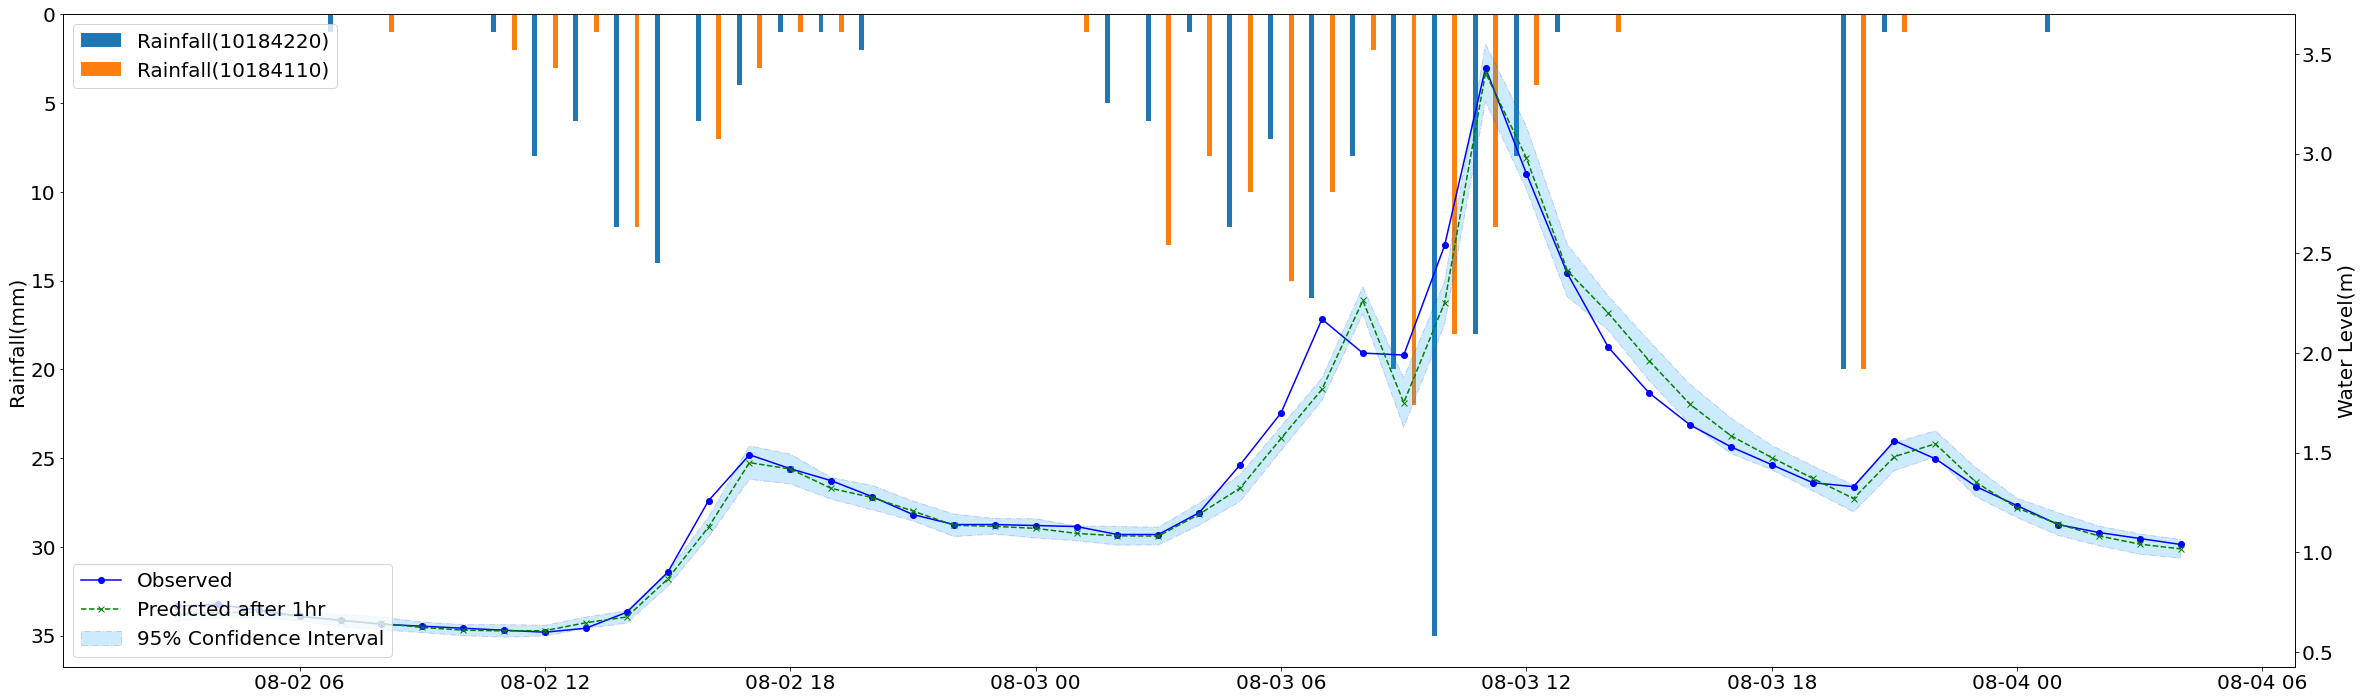

In [ ]:
df_predict = df_pred[0:50].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.005
ax1.bar(df_predict['Date'] - datetime.timedelta(minutes=15), df_predict['10184220'], width=width)
ax1.bar(df_predict['Date'] + datetime.timedelta(minutes=15), df_predict['10184110'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
ax1.legend(('Rainfall(10184220)','Rainfall(10184110)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=1, linestyle='dashdot', antialiased=True)
ax2.legend(('Observed','Predicted after 1hr', '95% Confidence Interval'), loc='lower left', prop={'size': 20})
ax2.set_ylabel('Water Level(m)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

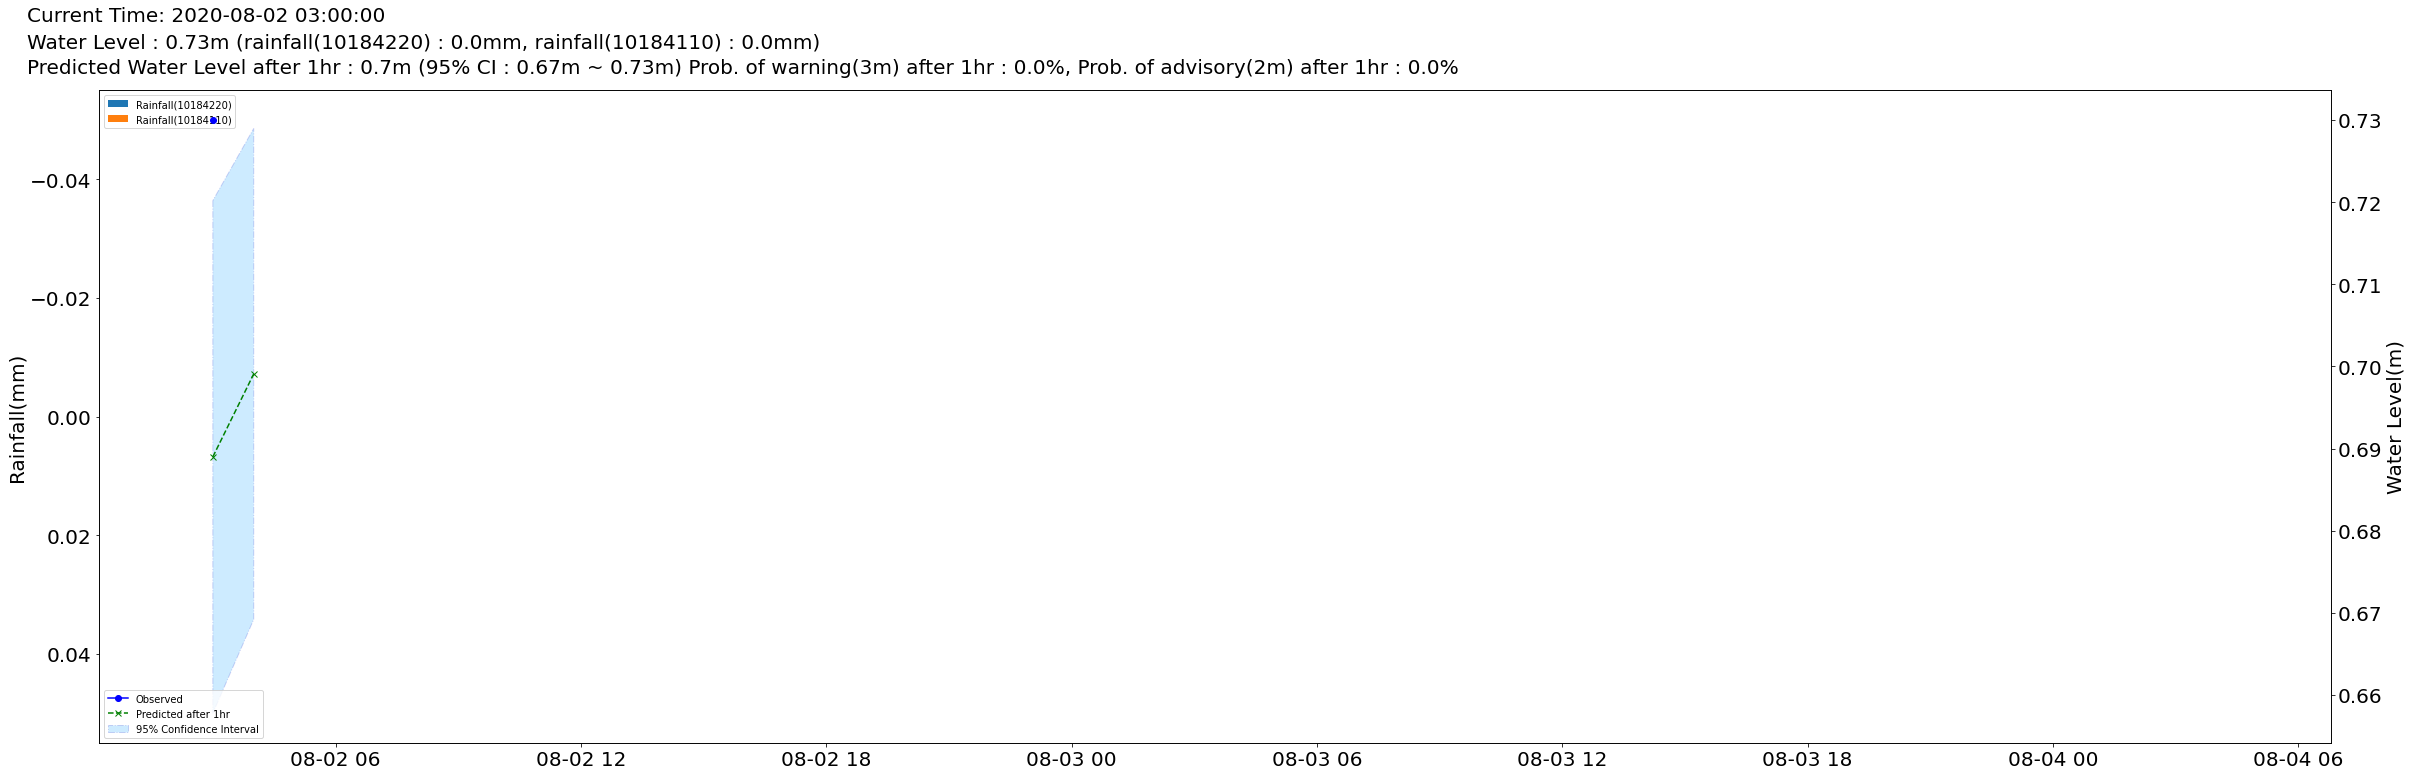

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

frame = 1

df_predict = df_pred[0:50][['Date']].merge(df_pred[0:frame+1], how='left', on = 'Date').copy()
df_predict['Obs'][frame] = float("nan")
df_predict['10184110'] = df_predict['10184110'].fillna(0)
df_predict['10184220'] = df_predict['10184220'].fillna(0)

water_level = df_predict['Pred'][frame]
prob_warning = df_predict['Prob_warn'][frame]

fig = plt.figure(figsize=(40,12))

#ax2.bar(df_predict['Date'] + datetime.timedelta(minutes=15), df_predict['Prob_adv'], color='orange', width=width)
#ax1.legend(('Prob. of warning','Prob. of advisory'), loc='upper left')

def update(frame):
  frame = frame + 1
  df_predict = df_pred[0:50][['Date']].merge(df_pred[0:frame+1], how='left', on = 'Date').copy()
  df_predict['Obs'][frame] = float("nan")
  df_predict['10184110'][frame] = float("nan")
  df_predict['10184220'][frame] = float("nan")

  df_predict['10184110'] = df_predict['10184110'].fillna(0)
  df_predict['10184220'] = df_predict['10184220'].fillna(0)
  
  water_level = df_predict['Pred'][frame]
  current_wl = df_predict['Obs'][frame-1]
  current_time = df_predict['Date'][frame-1]
  pred_time = df_predict['Date'][frame]

  rf_10184110 = df_predict['10184110'][frame-1]
  rf_10184220 = df_predict['10184220'][frame-1]

  upper = df_predict['Upper'][frame]
  lower = df_predict['Lower'][frame]
  prob_warning = df_predict['Prob_warn'][frame]
  prob_adv     = df_predict['Prob_adv'][frame]

  fig.clf()
  ax1 = fig.subplots()  
  width = 0.005
  ax1.bar(df_predict['Date'] - datetime.timedelta(minutes=15), df_predict['10184220'], width=width)
  ax1.bar(df_predict['Date'] + datetime.timedelta(minutes=15), df_predict['10184110'], width=width)
  ax1.set_ylabel('Rainfall(mm)', fontsize=20)
  ax1.legend(('Rainfall(10184220)','Rainfall(10184110)'), loc='upper left')
  ax1.invert_yaxis()
  
  ax2 = ax1.twinx()
  ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
  ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
  ax2.fill_between(df_predict['Date'], df_predict['Lower'], df_predict['Upper'],
                 alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                 linewidth=1, linestyle='dashdot', antialiased=True)
  ax2.legend(('Observed','Predicted after 1hr', '95% Confidence Interval'), loc='lower left')
  ax2.set_ylabel('Water Level(m)', fontsize=20)

  fig.text(0.1, 0.96, 'Current Time: ' + str(current_time), fontsize=20, color='black') 
  fig.text(0.1, 0.93, 'Water Level : ' + str(round(current_wl,2)) + 'm (rainfall(10184220) : ' + str(round(rf_10184220,2)) + 'mm, rainfall(10184110) : ' + str(round(rf_10184110,2)) + 'mm)', fontsize=20, color='black') 

  # Set tick font size
  for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	  label.set_fontsize(20)
   
  color = 'black'
  if prob_adv > 0.5 :
    color = 'orange'
  if prob_warning > 0.5 :
    color = 'red'  

  fig.text(0.1, 0.9, 'Predicted Water Level after 1hr : ' + str(round(water_level,2)) + 'm (95% CI : ' + str(round(lower,2)) + 'm ~ ' + str(round(upper,2)) + 'm)' + ' Prob. of warning(3m) after 1hr : ' + str(round(prob_warning*100,2))+ '%, ' + 'Prob. of advisory(2m) after 1hr : ' + str(round(prob_adv*100,2)) + '%', fontsize=20, color=color) 

  fig.canvas.draw()
  
ani = FuncAnimation(
        fig=fig, func=update,
        frames= 49, 
        interval = 1000,
        blit = False)
HTML(ani.to_html5_video())
